In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import anndata as ad
import seaborn as sns

In [2]:
sc.set_figure_params(figsize=(3,3), frameon=False)
sns.set_theme()
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [3]:
path = '/picb/bigdata/project/miaoyuanyuan/train/XChrom_analysis/2_cross_samples/s1d1_s2d1/0_preprocess/'
s1 = sc.read_h5ad(f'{path}/processed_data/train_rna.h5ad')
s2 = sc.read_h5ad(f'{path}/processed_data/test_rna.h5ad')
s1,s2

(AnnData object with n_obs × n_vars = 6224 × 12278
     obs: 'cell_type', 'batch', 'Samplename', 'n_genes'
     var: 'feature_types', 'gene_id', 'n_cells',
 AnnData object with n_obs × n_vars = 4220 × 12278
     obs: 'cell_type', 'batch', 'Samplename', 'n_genes'
     var: 'feature_types', 'gene_id', 'n_cells')

In [4]:
adata = s1.concatenate(s2, batch_key="batchid")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=32)

/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


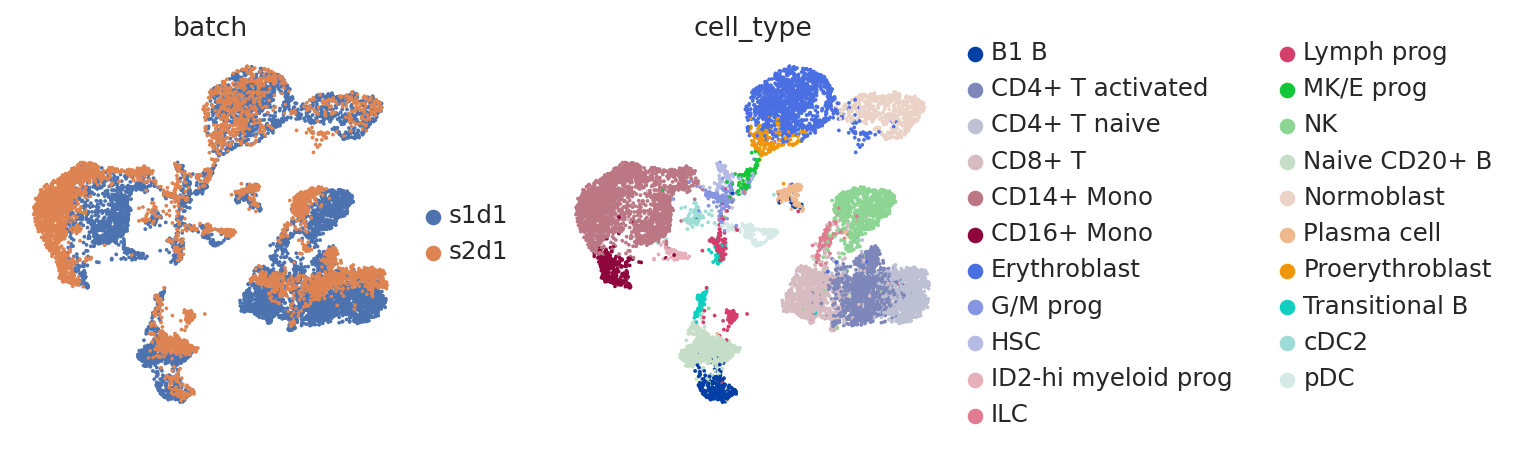

In [5]:
# Calculate the neighbors based on the PCA space before batch correction
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type'])

In [6]:
sce.pp.harmony_integrate(adata, 'batchid')
'X_pca_harmony' in adata.obsm

2025-07-04 14:04:35,510 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-04 14:04:37,504 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-04 14:04:37,576 - harmonypy - INFO - Iteration 1 of 10
2025-07-04 14:04:39,708 - harmonypy - INFO - Iteration 2 of 10
2025-07-04 14:04:41,711 - harmonypy - INFO - Iteration 3 of 10
2025-07-04 14:04:43,614 - harmonypy - INFO - Converged after 3 iterations


True

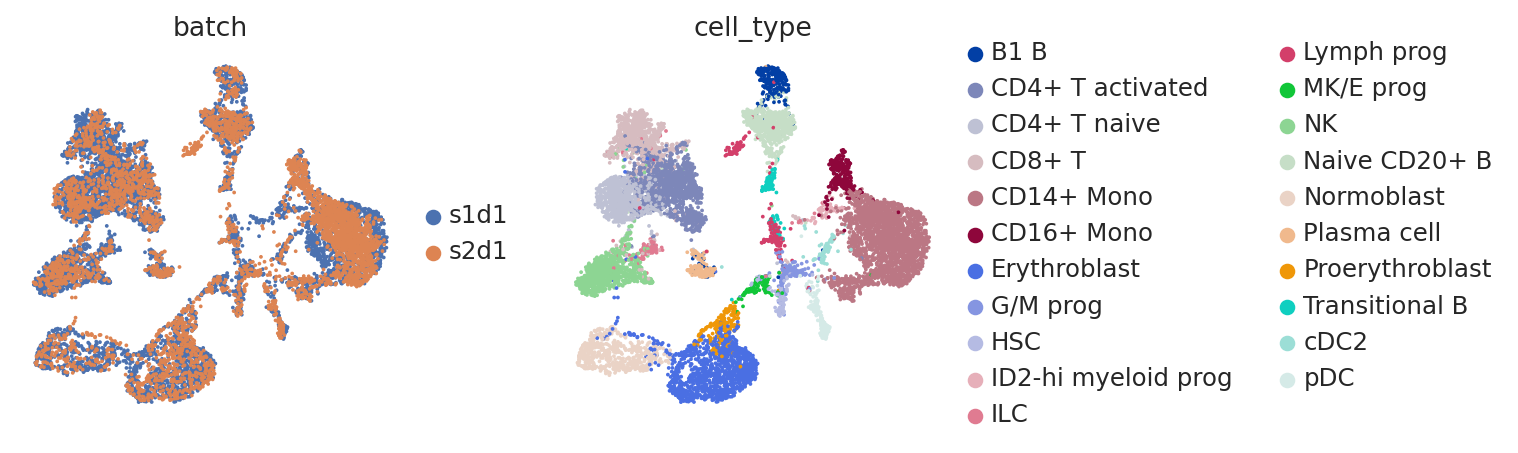

In [7]:
# Calculate the neighbors based on the PCA space after batch correction
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type'])

In [9]:
adata.obs.index = adata.obs.index.str.replace(r'-\d+$', '', regex=True)
print(adata.obs.index[:5])

Index(['TAGTTGTCACCCTCAC-1-s1d1', 'CTATGGCCATAACGGG-1-s1d1',
       'CCGCACACAGGTTAAA-1-s1d1', 'TCATTTGGTAATGGAA-1-s1d1',
       'ACCACATAGGTGTCCA-1-s1d1'],
      dtype='object')


In [10]:
adatad1 = adata[adata.obs['batch']=='s1d1']
adatad2 = adata[adata.obs['batch']=='s2d1']
adatad1.write(f'{path}/processed_data/train_rna_harmony.h5ad')
adatad2.write(f'{path}/processed_data/test_rna_harmony.h5ad')